In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline

from cross_val import cross_val, cross_val_simple

In [2]:
data = pd.read_pickle('data_clean.pickle')

## Exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 75
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   team                      457 non-null    object 
 1   season                    457 non-null    object 
 2   assists_per_game          457 non-null    float64
 3   goals_per_game            457 non-null    float64
 4   penalty_corners_per_game  457 non-null    float64
 5   save_percentage           457 non-null    float64
 6   saves_per_game            457 non-null    float64
 7   scoring_margin            457 non-null    float64
 8   shutouts_per_game         457 non-null    float64
 9   winning_percentage        457 non-null    float64
 10  goals_against_per_game    457 non-null    float64
dtypes: float64(9), object(2)
memory usage: 42.8+ KB


In [4]:
data.describe()

,assists_per_game,goals_per_game,penalty_corners_per_game,save_percentage,saves_per_game,scoring_margin,shutouts_per_game,winning_percentage,goals_against_per_game
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,1.819037,2.315996,6.077899,0.714961,5.262739,0.225259,0.194267,0.525131,2.058725
std,0.679349,0.784364,1.359991,0.051645,1.675367,1.329255,0.117140,0.190973,0.762821
min,0.280000,0.680000,3.120000,0.554000,1.750000,-5.102222,0.050000,0.059000,0.652174
25%,1.300000,1.720000,5.160000,0.679000,4.000000,-0.582353,0.110000,0.400000,1.473684
50%,1.780000,2.280000,6.040000,0.714000,5.050000,0.220000,0.170000,0.529000,1.947368
75%,2.260000,2.830000,7.000000,0.755000,6.220000,1.130000,0.260000,0.667000,2.500000
max,4.170000,5.570000,10.880000,0.850000,11.760000,4.910000,0.670000,1.000000,6.250000


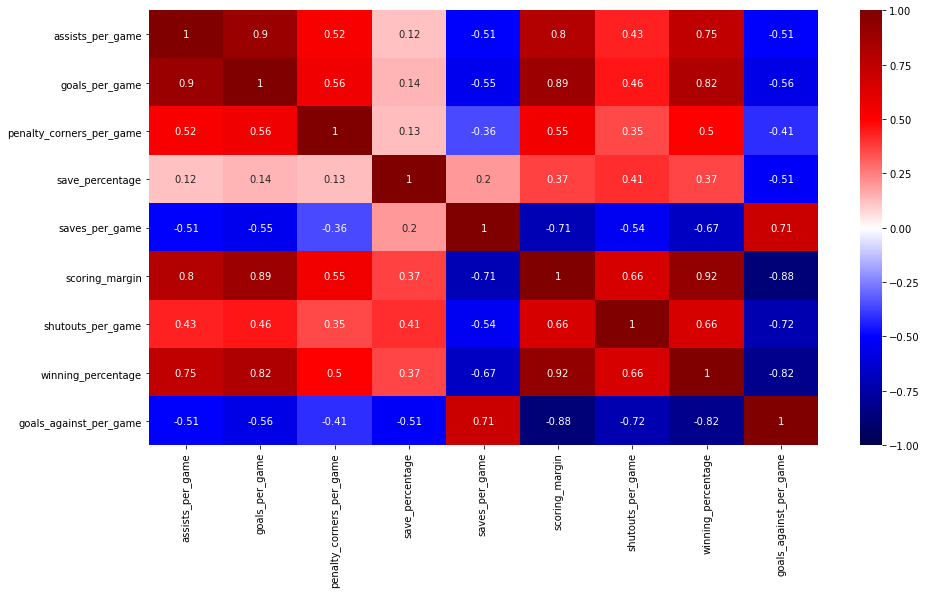

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

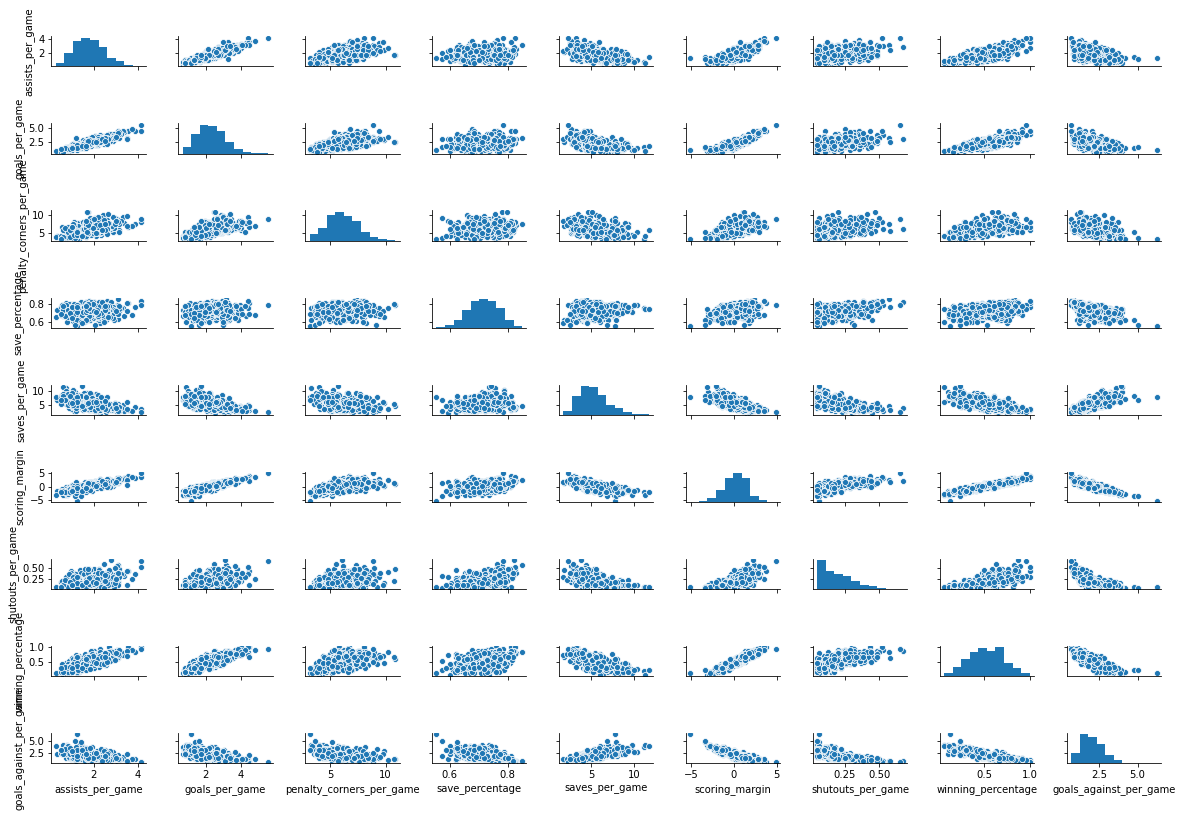

In [6]:
sns.pairplot(data, height=1.2, aspect=1.5);

## Modeling

### Train test split

Split data, keep last season as test data

In [7]:
test = data[data.season == '2019-20']
train_val = data[data.season != '2019-20']
train_val_y = train_val.winning_percentage
train_val_X = train_val.drop(columns = ['team', 'season', 'winning_percentage'])

### First model check

Sanity check first rough model with all features. In Statsmodels so I can see the p-values

In [8]:
train_val_X_const = sm.add_constant(train_val_X)
lr1 = sm.OLS(train_val_y, train_val_X_const)
model = lr1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     winning_percentage   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     330.6
Date:                Mon, 24 Aug 2020   Prob (F-statistic):          1.61e-166
Time:                        21:33:05   Log-Likelihood:                 501.85
No. Observations:                 391   AIC:                            -985.7
Df Residuals:                     382   BIC:                            -950.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2279      0.149     -1.525      0.128      -0.522       0.066
assists_per_game             0.0136      0.011      1.203      0.230      -0.009       0.036
goals_per_game               0.2820      0.072      3.908      0.000       0.140       0.424
penalty_corners_per_game    -0.0009      0.003     -0.284      0.777      -0.007       0.005
save_percentage              0.9888      0.213      4.634      0.000       0.569       1.408
saves_per_game              -0.0347      0.008     -4.313      0.000      -0.051      -0.019
scoring_margin              -0.1761      0.074     -2.384      0.018      -0.321      -0.031
shutouts_per_game            0.0942      0.046      2.047      0.041       0.004       0.185
goals_against_per_game      -0.2051      0.074     -2.786      0.006      -0.350      -0.060
==============================================================================
Omnibus:                        3.524   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                3.139
Skew:                          -0.142   Prob(JB):                        0.208
Kurtosis:                       2.666   Cond. No.                         688.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Check output vs sklearn

In [9]:
lr2 = LinearRegression()
lr2.fit(train_val_X, train_val_y)
lr2.score(train_val_X,train_val_y)

0.8737993559678501

This leads me to leave out penalty_corners_per_game and assists_per_game

In [10]:
train_val_X = train_val.drop(columns = ['team', 'season', 'winning_percentage', 'penalty_corners_per_game', 'assists_per_game'])

In [11]:
train_val_X_const = sm.add_constant(train_val_X)
lr1 = sm.OLS(train_val_y, train_val_X_const)
model = lr1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     winning_percentage   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     441.2
Date:                Mon, 24 Aug 2020   Prob (F-statistic):          7.64e-169
Time:                        21:33:06   Log-Likelihood:                 501.09
No. Observations:                 391   AIC:                            -988.2
Df Residuals:                     384   BIC:                            -960.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.2429      0.146     -1.659      0.098      -0.531       0.045
goals_per_game             0.2876      0.072      4.012      0.000       0.147       0.429
save_percentage            1.0046      0.212      4.741      0.000       0.588       1.421
saves_per_game            -0.0355      0.008     -4.448      0.000      -0.051      -0.020
scoring_margin            -0.1717      0.074     -2.329      0.020      -0.317      -0.027
shutouts_per_game          0.0948      0.046      2.075      0.039       0.005       0.185
goals_against_per_game    -0.1986      0.073     -2.712      0.007      -0.343      -0.055
==============================================================================
Omnibus:                        3.278   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                2.891
Skew:                          -0.127   Prob(JB):                        0.236
Kurtosis:                       2.664   Cond. No.                         484.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now split into train and val (test has already been set aside)

### Train val split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_val_X, train_val_y, test_size=.25)

In [13]:
lm3 = LinearRegression()

lm3.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lm3.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm3.score(X_val, y_val):.3f}')

Linear Regression train R^2: 0.874
Linear Regression val R^2: 0.868


This is the base model I'll be trying to improve on

### Regularization

In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)

In [15]:
lm_reg = Ridge(alpha= 0.001)
lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

Ridge Regression train R^2: 0.874
Ridge Regression val R^2: 0.868


In [16]:
lasso_model = Lasso(alpha= 0.001)
lasso_model.fit(X_train_scaled, y_train)
print(f'LASSO Regression train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LASSO Regression val R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')

LASSO Regression train R^2: 0.872
LASSO Regression val R^2: 0.866


It seems like increasing alpha for both regularizations reduces R2, so I am taking this to mean that removing features (LASSO) or reducing coefficient flexibility (Ridge) does not improve my model. Regularization is not the way to go

### Try a CV approach

In [17]:
X, y = np.array(train_val_X), np.array(train_val_y)

In [18]:
cross_val(X, y, ridge_a = 0.001, lasso_a = 0.001)

Simple mean cv r^2 train: 0.874 +- 0.005
Simple mean cv r^2 valid: 0.865 +- 0.022


Ridge mean cv r^2 train: 0.865 +- 0.022
Ridge mean cv r^2 valid: 0.865 +- 0.022


Lasso mean cv r^2 train: 0.863 +- 0.022
Lasso mean cv r^2 valid: 0.863 +- 0.022


In [19]:
# get all columns from data_clean.pickle, before removals
train_val_X_more = train_val.drop(columns = ['team', 'season', 'winning_percentage'])
X_more, y = np.array(train_val_X_more), np.array(train_val_y)

In [20]:
cross_val(X_more, y, ridge_a = 0.001, lasso_a = 0.001)

Simple mean cv r^2 train: 0.874 +- 0.007
Simple mean cv r^2 valid: 0.863 +- 0.035


Ridge mean cv r^2 train: 0.863 +- 0.035
Ridge mean cv r^2 valid: 0.863 +- 0.035


Lasso mean cv r^2 train: 0.860 +- 0.035
Lasso mean cv r^2 valid: 0.860 +- 0.035


### Combinations of features - manual

In [21]:
X_sel, y = np.array(train_val_X[['goals_per_game', 'goals_against_per_game', 'save_percentage', 'saves_per_game']]), np.array(train_val_y)

In [22]:
cross_val(X_sel, y, ridge_a = 1, lasso_a = 1)

Simple mean cv r^2 train: 0.871 +- 0.008
Simple mean cv r^2 valid: 0.854 +- 0.035


Ridge mean cv r^2 train: 0.855 +- 0.034
Ridge mean cv r^2 valid: 0.855 +- 0.034


Lasso mean cv r^2 train: -0.037 +- 0.032
Lasso mean cv r^2 valid: -0.037 +- 0.032


It seems like the combination of saves per game and save percentage improves R2 from 0.86 to 0.87. The other features don't add much on top of that

### Polynomial

In [23]:
X_pl, y = np.array(train_val_X), np.array(train_val_y)

In [24]:
poly = PolynomialFeatures(2)
X_pol = poly.fit_transform(train_val_X)
cross_val(X_pol, y, ridge_a = 3, lasso_a = 0.01)

Simple mean cv r^2 train: 0.852 +- 0.052
Simple mean cv r^2 valid: 0.841 +- 0.031


Ridge mean cv r^2 train: 0.873 +- 0.034
Ridge mean cv r^2 valid: 0.873 +- 0.034


Lasso mean cv r^2 train: 0.852 +- 0.021
Lasso mean cv r^2 valid: 0.852 +- 0.021


In [25]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)
cross_val(X_pol, y, ridge_a = 5, lasso_a = 0.01)

Simple mean cv r^2 train: 0.855 +- 0.039
Simple mean cv r^2 valid: 0.829 +- 0.053


Ridge mean cv r^2 train: 0.873 +- 0.011
Ridge mean cv r^2 valid: 0.873 +- 0.011


Lasso mean cv r^2 train: 0.852 +- 0.013
Lasso mean cv r^2 valid: 0.852 +- 0.013


No significant (or consistent) increase in R2 from including polynomials

### Pythagorean Expectation

In [26]:
train_val_X_more = train_val.drop(columns = ['team', 'season', 'winning_percentage'])
X_more, y = np.array(train_val_X_more), np.array(train_val_y)

In [27]:
X_pyth = train_val_X_more.copy()
pyth_degree = 1.02
X_pyth['pyth'] = (X_pyth.goals_per_game**pyth_degree / 
                 (X_pyth.goals_per_game + X_pyth.goals_against_per_game)**pyth_degree)
r2_score(y, X_pyth['pyth'])

0.8562415460911871

In [28]:
X_more, y = np.array(X_pyth['pyth']).reshape(-1,1), np.array(train_val_y)
cross_val(X_more, y, ridge_a = 6, lasso_a = 0.001)

Simple mean cv r^2 train: 0.879 +- 0.005
Simple mean cv r^2 valid: 0.874 +- 0.021


Ridge mean cv r^2 train: 0.874 +- 0.020
Ridge mean cv r^2 valid: 0.874 +- 0.020


Lasso mean cv r^2 train: 0.874 +- 0.021
Lasso mean cv r^2 valid: 0.874 +- 0.021


Coefficients for the Pythagorean Expectation as a single feature are ~1.18

In [29]:
X_more, y = np.array(X_pyth), np.array(train_val_y)
cross_val(X_more, y, ridge_a = 6, lasso_a = 0.001)

Simple mean cv r^2 train: 0.883 +- 0.010
Simple mean cv r^2 valid: 0.862 +- 0.049


Ridge mean cv r^2 train: 0.862 +- 0.048
Ridge mean cv r^2 valid: 0.862 +- 0.048


Lasso mean cv r^2 train: 0.863 +- 0.049
Lasso mean cv r^2 valid: 0.863 +- 0.049


Trying combinations in a loop with the Pythagorean Expectation included as a feature:

In [30]:
X, y = np.array(X_pyth[['assists_per_game', 'penalty_corners_per_game',
                     'save_percentage', 'shutouts_per_game', 'pyth']]), np.array(train_val_y)

In [31]:
cross_val_simple(X, y)

r^2 train: 0.881 +- 0.003
r^2 valid: 0.875 +- 0.013
rmse valid: 0.066 +- 0.003


In [32]:
X_pyth.columns

Index(['assists_per_game', 'goals_per_game', 'penalty_corners_per_game',
       'save_percentage', 'saves_per_game', 'scoring_margin',
       'shutouts_per_game', 'goals_against_per_game', 'pyth'],
      dtype='object')

In [33]:
for col in X_pyth.columns[0:-1]:
    mask = ['pyth', col]
    X, y = np.array(X_pyth[mask]), np.array(train_val_y)
    print(col)
    cross_val_simple(X, y)

assists_per_game
r^2 train: 0.879 +- 0.004
r^2 valid: 0.874 +- 0.022
rmse valid: 0.066 +- 0.003
goals_per_game
r^2 train: 0.879 +- 0.004
r^2 valid: 0.873 +- 0.019
rmse valid: 0.066 +- 0.002
penalty_corners_per_game
r^2 train: 0.879 +- 0.003
r^2 valid: 0.876 +- 0.011
rmse valid: 0.066 +- 0.004
save_percentage
r^2 train: 0.879 +- 0.005
r^2 valid: 0.876 +- 0.019
rmse valid: 0.066 +- 0.004
saves_per_game
r^2 train: 0.879 +- 0.005
r^2 valid: 0.873 +- 0.019
rmse valid: 0.066 +- 0.003
scoring_margin
r^2 train: 0.879 +- 0.005
r^2 valid: 0.872 +- 0.022
rmse valid: 0.066 +- 0.002
shutouts_per_game
r^2 train: 0.879 +- 0.008
r^2 valid: 0.871 +- 0.034
rmse valid: 0.066 +- 0.005
goals_against_per_game
r^2 train: 0.879 +- 0.004
r^2 valid: 0.873 +- 0.020
rmse valid: 0.066 +- 0.005


Look at p-values and coefficients

In [34]:
X_pyth_const = sm.add_constant(X_pyth)
X, y = X_pyth_const[['const', 'assists_per_game', 'penalty_corners_per_game',
                     'save_percentage', 'shutouts_per_game', 'pyth']], train_val_y
lr1 = sm.OLS(y, X)
model = lr1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     winning_percentage   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     569.4
Date:                Mon, 24 Aug 2020   Prob (F-statistic):          2.26e-175
Time:                        21:33:55   Log-Likelihood:                 513.13
No. Observations:                 391   AIC:                            -1014.
Df Residuals:                     385   BIC:                            -990.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.1329      0.052     -2.554      0.011      -0.235      -0.031
assists_per_game             0.0163      0.008      1.946      0.052      -0.000       0.033
penalty_corners_per_game    -0.0032      0.003     -1.085      0.279      -0.009       0.003
save_percentage              0.0846      0.075      1.127      0.260      -0.063       0.232
shutouts_per_game            0.0608      0.041      1.465      0.144      -0.021       0.142
pyth                         1.1019      0.050     22.217      0.000       1.004       1.199
==============================================================================
Omnibus:                        1.557   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.459   Jarque-Bera (JB):                1.555
Skew:                          -0.089   Prob(JB):                        0.459
Kurtosis:                       2.747   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This will be my final model to test

### Train final model, check assumptions

In [35]:
pyth_degree = 1.02
data['pyth'] = (data.goals_per_game**pyth_degree / 
                 (data.goals_per_game + data.goals_against_per_game)**pyth_degree)
test = data[data.season == '2019-20']
train_val = data[data.season != '2019-20']
train_val_y = train_val.winning_percentage
train_val_X = train_val.drop(columns = ['team', 'season', 'winning_percentage'])
test_X = test.drop(columns = ['winning_percentage'])
test_y = test.winning_percentage

In [36]:
X, y = np.array(train_val_X[['assists_per_game', 'penalty_corners_per_game',
                     'save_percentage', 'shutouts_per_game', 'pyth']]), np.array(train_val_y)
X_t, y_t = np.array(test_X[['assists_per_game', 'penalty_corners_per_game',
                     'save_percentage', 'shutouts_per_game', 'pyth']]), np.array(test_y)

In [37]:
lm = LinearRegression()
lm.fit(X, y)
r2 = lm.score(X_t, y_t)
rmse = sqrt(mean_squared_error(y_t, lm.predict(X_t)))
print(f'r2: {r2} | rmse: {rmse}')

r2: 0.8763202185277328 | rmse: 0.07042777729946144


In [38]:
list(zip(['assists_per_game', 'penalty_corners_per_game',
                     'save_percentage', 'shutouts_per_game', 'pyth'], lm.coef_))

[('assists_per_game', 0.016345568373695208),
 ('penalty_corners_per_game', -0.003194080210049327),
 ('save_percentage', 0.08460463018893294),
 ('shutouts_per_game', 0.060767630274908196),
 ('pyth', 1.1018718714925841)]

In [39]:
X_const = sm.add_constant(X)
lr1 = sm.OLS(y, X_const)
model = lr1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     569.4
Date:                Mon, 24 Aug 2020   Prob (F-statistic):          2.26e-175
Time:                        21:34:08   Log-Likelihood:                 513.13
No. Observations:                 391   AIC:                            -1014.
Df Residuals:                     385   BIC:                            -990.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1329      0.052     -2.554      0.011      -0.235      -0.031
x1             0.0163      0.008      1.946      0.052      -0.000       0.033
x2            -0.0032      0.003     -1.085      0.279      -0.009       0.003
x3             0.0846      0.075      1.127      0.260      -0.063       0.232
x4             0.0608      0.041      1.465      0.144      -0.021       0.142
x5             1.1019      0.050     22.217      0.000       1.004       1.199
==============================================================================
Omnibus:                        1.557   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.459   Jarque-Bera (JB):                1.555
Skew:                          -0.089   Prob(JB):                        0.459
Kurtosis:                       2.747   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
train_val['yhat'] = lm.predict(X)
train_val['res'] = train_val.winning_percentage - train_val.yhat

<ipython-input-40-50bad99b4e34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val['yhat'] = lm.predict(X)
<ipython-input-40-50bad99b4e34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val['res'] = train_val.winning_percentage - train_val.yhat


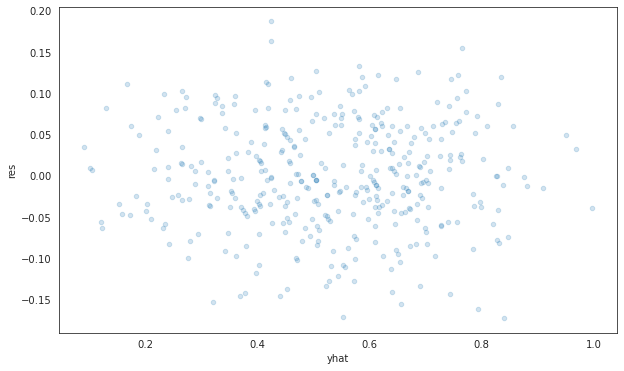

In [41]:
with sns.axes_style('white'):
    plot=train_val.plot(kind='scatter',
                  x='yhat',y='res',alpha=0.2,figsize=(10,6))

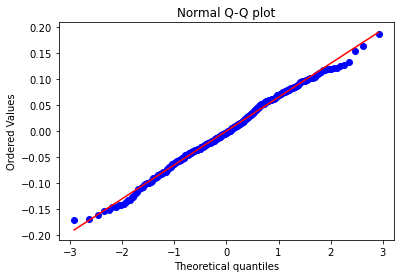

In [42]:
stats.probplot(train_val['res'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

The assumptions for linear regression look to be satisfied, with the residuals not showing an obvious pattern and the Q-Q plot looking pretty linear.

### Using the outcome

To use the outcome, I am writing the final table to excel, but it will need the number of total games played so I can multiply by the predicted win percentage.

In [62]:
test['predicted'] = lm.predict(X_t)
data_raw = pd.read_pickle('data.pickle')
games = data_raw[data_raw.season == '2019-20'][['team', 'games']]
output = test.merge(games, on = 'team', how = 'left')
output.to_excel('output.xlsx')